In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Import necessary libraries
import numpy as np
import pandas as pd
!pip install mat73
import mat73
import matplotlib.pyplot as plt
import os

# Define the list of input features
# input_features = ['ssh', 'sst', 'time', 'lat', 'lon']
input_features = ['ssh']
n_neurons = 64

# Load data from MATLAB files using mat73 library
ARGO = mat73.loadmat('ARGO_GoM_20220920.mat', use_attrdict=True)
# ARGO = mat73.loadmat('/content/drive/MyDrive/ARGO_GoM_20220920.mat', use_attrdict=True)

# Display keys in the loaded ARGO data
print(ARGO.keys())

# Extract and display the relevant arrays from the ARGO variable
pres = np.arange(5, 1800, 1, dtype=int)  # index
sal = ARGO.SAL[pres, :]
temp = ARGO.TEMP[pres, :]
lat = ARGO.LAT
lon = ARGO.LON
ssh = ARGO.SH1950
time = ARGO.TIME

# Data cleaning: remove profiles with NaNs
nan_index = np.logical_or(np.isnan(sal).any(axis=0), np.isnan(temp).any(axis=0))
sal = sal[:, ~nan_index]
temp = temp[:, ~nan_index]
lat = lat[~nan_index]
lon = lon[~nan_index]
ssh = ssh[~nan_index]
time = time[~nan_index]

print("Number of profiles: ", time.shape)
print("Number of depths: " , pres.shape)

Defaulting to user installation because normal site-packages is not writeable
dict_keys(['ADT_loc', 'ADTnoseason_loc', 'LAT', 'LON', 'PRES', 'RHO', 'SAL', 'SH1950', 'SIG', 'SPICE', 'TEMP', 'TIME'])
Number of profiles:  (4878,)
Number of depths:  (1795,)


## PCA functions

In [2]:
def center_data(data):
    return data - np.mean(data, axis=0)

def calculate_covariance(data):
    return np.cov(data, rowvar=False)

def get_eigenvalues_and_eigenvectors(covariance):
    return np.linalg.eig(covariance)

def select_principal_components(eigenvalues, eigenvectors, explained_variance=0.99):
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    cumulative_explained_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)
    n_components = np.argmax(cumulative_explained_variance >= explained_variance) + 1
    
    return eigenvectors[:, :n_components]

def transform_data(data, eigenvectors):
    return data.dot(eigenvectors)

def reconstruct_data(data_transformed, eigenvectors, mean):
    return data_transformed.dot(eigenvectors.T) + mean

# Get principal components

In [3]:
t_data = np.transpose(temp)
t_data_centered = center_data(t_data)
t_covariance_matrix = calculate_covariance(t_data_centered)
t_eigenvalues, t_eigenvectors = get_eigenvalues_and_eigenvectors(t_covariance_matrix)
t_principal_eigenvectors = select_principal_components(t_eigenvalues, t_eigenvectors)
t_data_transformed = transform_data(t_data_centered, t_principal_eigenvectors)
t_components = t_data_transformed.shape[1]
print(f'Temperature - Number of components: {t_components}')

s_data = np.transpose(sal)
s_data_centered = center_data(s_data)
s_covariance_matrix = calculate_covariance(s_data_centered)
s_eigenvalues, s_eigenvectors = get_eigenvalues_and_eigenvectors(s_covariance_matrix)
s_principal_eigenvectors = select_principal_components(s_eigenvalues, s_eigenvectors)
s_data_transformed = transform_data(s_data_centered, s_principal_eigenvectors)
s_components = s_data_transformed.shape[1]
print(f'Salinity - Number of components: {s_components}')

Temperature - Number of components: 6
Salinity - Number of components: 11


In [4]:
def plot_profiles(true_profile, reconstructed_profile, parameter, depths, profile_index, ax):
    ax.plot(true_profile, depths, label='PCA Profile', linewidth = 4)
    ax.plot(reconstructed_profile, depths, label='Synthetic Profile', linewidth = 2)
    ax.invert_yaxis()
    ax.set_xlabel(parameter)
    ax.set_ylabel('Depth (m)')
    ax.grid()



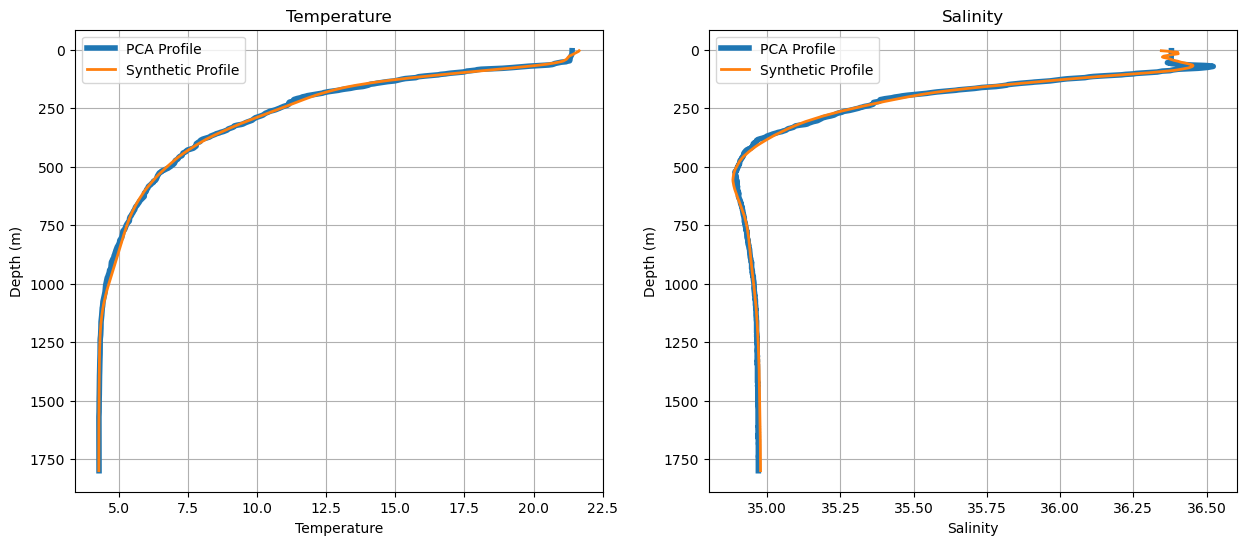

In [5]:
single_profile_index = 1

# Temperature
t_single_profile_centered = t_data_centered[single_profile_index] # Gets single profile
t_single_profile_transformed = transform_data(t_single_profile_centered, t_principal_eigenvectors) # transforms it
t_single_profile_mean = np.mean(t_data, axis=0)
t_single_reconstructed_profile = reconstruct_data(t_single_profile_transformed, t_principal_eigenvectors, t_single_profile_mean)
t_true_profile = t_data[single_profile_index]

# Salinity
s_single_profile_centered = s_data_centered[single_profile_index]
s_single_profile_transformed = transform_data(s_single_profile_centered, s_principal_eigenvectors)
s_single_profile_mean = np.mean(s_data, axis=0)
s_single_reconstructed_profile = reconstruct_data(s_single_profile_transformed, s_principal_eigenvectors, s_single_profile_mean)
s_true_profile = s_data[single_profile_index]

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

plot_profiles(t_true_profile, t_single_reconstructed_profile, 'Temperature', pres, single_profile_index, axes[0])
plot_profiles(s_true_profile, s_single_reconstructed_profile, 'Salinity', pres, single_profile_index, axes[1])
axes[0].legend()
axes[1].legend()
axes[0].set_title('Temperature')
axes[1].set_title('Salinity')

plt.show()

At this point, our label data are 6 components for each temperature profile and 11 components for each salinity profile. This is stored in t_data_transformed and s_data_transformed, respectively.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define the list of input features
# input_features = ['pres', 'ssh', 'sst', 'time', 'lat', 'lon']
input_features = ['ssh']
output_features = ['temp', 'sal']
# output_features = ['temp']
# output_features = ['sal']
d = len(input_features) # input dimension
od = len(output_features)

print(od)

# Select the columns corresponding to the input features
X_cols = [ssh] # if using more parameters, just add
X = np.column_stack(X_cols)
y_cols = [t_data_transformed, s_data_transformed]
# y_cols = [t_data_transformed]
# y_cols = [s_data_transformed]
y = np.column_stack(y_cols)
# print(y.shape)
od = y.shape[1] # output dimension

indices = np.arange(len(ssh))

X_train, X_val_test, y_train, y_val_test, i_train, i_val_test = train_test_split(X, y, indices, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test, i_val, i_test = train_test_split(X_val_test, y_val_test, i_val_test, test_size=0.5, random_state=42)

m_test = len(y_test) # number of test cases
m_train = len(y_train) # number of train cases

# Normalize the input data using z-score normalization
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

print(X_train.shape)
print(y_train.shape)

2
(3902, 1)
(3902, 17)


# CONTINUE FROM HERE
## NN architecture

In [18]:
import tensorflow as tf
print('Using TensorFlow version,', tf.__version__)
import datetime
from keras.models import Sequential
from keras.layers import Layer, InputLayer, Activation, Dense
from tensorflow.keras import initializers
import gc # garbage collector
# call garbage collector for unused references
gc.collect() 
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow.keras.backend as K

# Define the early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


Using TensorFlow version, 2.12.0


Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

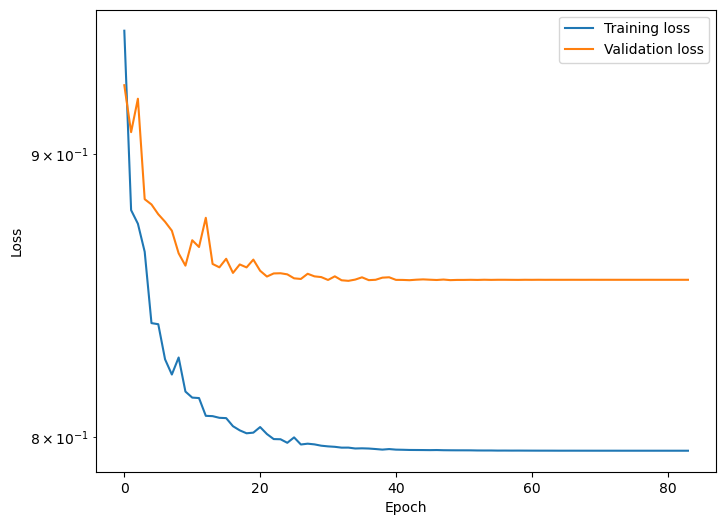

16/16 [==============================] - 0s 2ms/step - loss: 0.8536
MSE on train set: 0.7955998778343201
MSE on test set: 0.7797305583953857
MSE on validation set: 0.8535863161087036
R-squared on validation set: 0.19490879083908522


In [19]:
# Define the log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Define the TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Define the neural network architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(n_neurons, activation='tanh', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(n_neurons, activation='tanh'),
    tf.keras.layers.Dense(n_neurons, activation='tanh'),
    tf.keras.layers.Dense(y_train.shape[1], activation=None)
])

# set the decay schedule for the learning rate as exponentially decaying 
init_rate = 0.01
decay_steps = 500
decay_rate = np.exp(0.2*(np.log(5e-4)-np.log(init_rate)))
exp_decay_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_rate, decay_steps, decay_rate, staircase = False, name = None
)

# def cosine_similarity_loss(y_true, y_pred):
#     y_true_norm = K.l2_normalize(y_true, axis=-1)
#     y_pred_norm = K.l2_normalize(y_pred, axis=-1)
#     return 1 - K.mean(K.sum(y_true_norm * y_pred_norm, axis=-1))


# Define the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=exp_decay_schedule)
model.compile(optimizer=optimizer, loss='mse')
# model.compile(optimizer=optimizer, loss=cosine_similarity_loss)

# # Compile the model
# model.compile(optimizer='adam', loss='mse')

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=32, 
                    callbacks=[tensorboard_callback, early_stopping_callback], verbose=10)

# Evaluate the model on test set
mse_test = model.evaluate(X_test, y_test)
mse_train = model.evaluate(X_train, y_train)

# Save the model
# model.save('model.h5')

# Plot the loss history during training
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# filename = f"figures/0loss_NN_GEM.jpg"
# plt.savefig(filename)

plt.show()

# Calculate predictions on validation set
y_pred = model.predict(X_val)

# Calculate and print mean squared error on validation set
mse_val = model.evaluate(X_val, y_val)
print('MSE on train set:', mse_train)
print('MSE on test set:', mse_test)
print('MSE on validation set:', mse_val)

# Calculate and print R-squared on validation set
r2_val = r2_score(y_val, y_pred)
print('R-squared on validation set:', r2_val)


In [21]:
# Initialize list to store % differences between true and predicted profiles
t_percent_diff = []
t_max_dif = -1
t_max_index = []

s_percent_diff = []
s_max_dif = -1
s_max_index = []

if not os.path.exists('figures'):
    os.makedirs('figures')

# Initialize table to store performance metrics
metrics_table = []

# Iterate over each row in y_val
for val_profile_index in range(y_val.shape[0]):
    # Separate the predicted temperature and salinity PCA coefficients
    t_pred_pca = y_pred[val_profile_index, :t_components]
    s_pred_pca = y_pred[val_profile_index, t_components:]
    
    # Reconstruct the temperature and salinity profiles using the respective eigenvectors
    t_pred_reconstructed = reconstruct_data(t_pred_pca, t_principal_eigenvectors, t_single_profile_mean)
    s_pred_reconstructed = reconstruct_data(s_pred_pca, s_principal_eigenvectors, s_single_profile_mean)
    
    # Get the true profiles from the validation set
    t_true_val_profile = y_val[val_profile_index, :t_data_transformed.shape[1]]
    s_true_val_profile = y_val[val_profile_index, t_data_transformed.shape[1]:]
    
    # Reconstruct the true temperature and salinity profiles using the respective eigenvectors
    t_true_reconstructed = reconstruct_data(t_true_val_profile, t_principal_eigenvectors, t_single_profile_mean)
    s_true_reconstructed = reconstruct_data(s_true_val_profile, s_principal_eigenvectors, s_single_profile_mean)
    
    # Calculate MSE and R-squared values
    t_mse = mean_squared_error(t_true_reconstructed, t_pred_reconstructed)
    t_r2 = r2_score(t_true_reconstructed, t_pred_reconstructed)
    s_mse = mean_squared_error(s_true_reconstructed, s_pred_reconstructed)
    s_r2 = r2_score(s_true_reconstructed, s_pred_reconstructed)
    
    # Append performance metrics to table
    metrics_table.append([t_mse, t_r2, s_mse, s_r2])
    
    # Calculate % difference between true and predicted profiles
    t_cur_diff = np.mean(np.abs((temp[:, i_val[val_profile_index]] - t_pred_reconstructed) / t_true_reconstructed)) * 100
    s_cur_diff = np.mean(np.abs((sal[:, i_val[val_profile_index]] - s_pred_reconstructed) / s_true_reconstructed)) * 100

    t_percent_diff.append(t_cur_diff)
    s_percent_diff.append(s_cur_diff)
    
    if (t_cur_diff > t_max_dif):
        t_max_dif = t_cur_diff
        t_max_index = val_profile_index
        
    if (s_cur_diff > s_max_dif):
        s_max_dif = s_cur_diff
        s_max_index = val_profile_index
    
    # Plot the true and reconstructed profiles
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    # Add titles to subplots with performance metrics
    axes[0].set_title(f'Temperature (MSE: {t_mse:.2f}, R2: {t_r2:.2f})')
    axes[1].set_title(f'Salinity (MSE: {s_mse:.2f}, R2: {s_r2:.2f})')
    
    plot_profiles(t_true_reconstructed, t_pred_reconstructed, 'Temperature (°C)', pres, val_profile_index, axes[0])
    plot_profiles(s_true_reconstructed, s_pred_reconstructed, 'Salinity', pres, val_profile_index, axes[1])
    axes[0].plot(temp[:, i_val[val_profile_index]], pres, label='True Profile', linewidth = 2, linestyle = ':')
    axes[1].plot(sal[:, i_val[val_profile_index]], pres, label='True Profile', linewidth = 2, linestyle = ':')
    axes[0].legend()
    axes[1].legend()
    axes[0].set_title('Temperature')
    axes[1].set_title('Salinity')
    fig.suptitle(f'Profile {val_profile_index}, SSH = {ssh[i_val[val_profile_index]]}')

    # Save the plot
    plt.savefig(f'figures/val_profile_{val_profile_index}.png')
    plt.close()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # Add titles to subplots with performance metrics
    axes[0].set_title(f'Temperature (MSE: {t_mse:.2f}, R2: {t_r2:.2f})')
    axes[1].set_title(f'Salinity (MSE: {s_mse:.2f}, R2: {s_r2:.2f})')

    plot_profiles(t_true_reconstructed, t_pred_reconstructed, 'Temperature (°C)', pres, val_profile_index, axes[0])
    plot_profiles(s_true_reconstructed, s_pred_reconstructed, 'Salinity', pres, val_profile_index, axes[1])
    axes[0].plot(temp[:, i_val[val_profile_index]], pres, label='True Profile', linewidth = 2, linestyle = ':')
    axes[1].plot(sal[:, i_val[val_profile_index]], pres, label='True Profile', linewidth = 2, linestyle = ':')
    axes[0].legend()
    axes[1].legend()
    axes[0].set_title('Temperature')
    axes[1].set_title('Salinity')
    fig.suptitle(f'Profile {val_profile_index}, SSH = {ssh[i_val[val_profile_index]]}')
    # Set y-axis limits to show only the first 300 meters ?
    axes[0].set_ylim(300, 0)
    axes[1].set_ylim(300, 0)

    # Save the plot
    plt.savefig(f'figures/surf_val_profile_{val_profile_index}.png')
    plt.close()

# Convert metrics table to Pandas DataFrame
metrics_table = pd.DataFrame(metrics_table, columns=['Temp MSE', 'Temp R2', 'Salinity MSE', 'Salinity R2'])

# Calculate and print the average % difference between true and predicted T and S profiles
print(f"Average % difference in Temperature: {np.mean(t_percent_diff):.2f}%")
print(f"Average % difference in Salinity: {np.mean(s_percent_diff):.2f}%")
print(f"Max % difference in Temperature: {t_max_dif:.2f}%, profile {t_max_index}")
print(f"Max % difference in Salinity: {s_max_dif:.2f}%, profile {s_max_index}")

# Export metrics table as CSV
metrics_table.to_csv('metrics_table.csv', index=False)

Average % difference in Temperature: 6.74%
Average % difference in Salinity: 0.20%
Max % difference in Temperature: 20.92%, profile 83
Max % difference in Salinity: 0.54%, profile 202
